### The *Wellness Watchers*

# Best Neighborhood for Wellbeing

## By Joshua Sakolsky-Madaras & Sumay Sethia

________________________________________________________________________________________________

## Metrics:

In order to find the neighborhoods in Pittsburgh with the best wellness we decided to measure three different metrics of mortalities in that area, the amount of particulate matter in the air, and the amount of arrests made in that area. Points are weighted evenly across the 3 categories and are awarded in reverse order of how good thier metric is. So the neighborhood with the least overall score is the best.

For instance if a neighborhood has the lowest mortalities they recieve 0 points in that category and if it has the highest mortalities it recieves the maximum number of points, equal to the number of neighborhoods on the graph.

## Mortality Indicators

### By Joshua Sakolsky-Madaras

_________________________________________________________________________________________________________________________________

A good way to measure the wellness of a neighborhood is how many people pass in that neighborhood.  Deaths are very sad and bring down the mood of families and friends alike, contributing to a decline of mental wellness.  This portion of our project focuses on figuring out which neighborhoods in Pittsburgh have the lowest number of mortalities.

Data Set Used: [Allegheny County Mortality Indicators](https://data.wprdc.org/dataset/allegheny-county-mortality-indicators)

This dataset contains "counts of deaths by race (total, Black, white) by age grouping and cause of death by Census Tract aggregated over a five-year period (2014-18). Data extracted from Pennsylvania's Electronic Death Registry System (EDRS) with the following disclaimer: 'These data were provided by the Pennsylvania Department of Health. The Department specifically disclaims responsibility for any analyses, interpretations, or conclusions.'"

In [14]:
# Imports Needed
import pandas as pd
import geopandas as gpd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Read CSV file
df = pd.read_csv("mortality_by_tract.csv")

# Show the first 5 rows of the dataframe
df.head(5)

,Census_Tract,Black Total Mortality,White Total Mortality,Total Mortality,Alzheimer's disease,Cancer,Chronic liver disease and cirrhosis,Chronic lower respiratory diseases,Diabetes,Flu and pneumonia,Heart disease,Homicide,Septicemia,Stroke,Suicide,Unintentional injuries
0,42003010300,24.0,23.0,47,NaN,9.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,10.0
1,42003020100,37.0,84.0,121,NaN,23.0,NaN,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,15.0
2,42003020300,NaN,8.0,13,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
3,42003030500,176.0,16.0,192,NaN,54.0,NaN,7.0,NaN,NaN,50.0,NaN,NaN,7.0,NaN,6.0
4,42003040200,57.0,35.0,92,NaN,13.0,NaN,7.0,NaN,NaN,19.0,NaN,NaN,5.0,NaN,11.0


## Step 1: Fixing Nulls, Adding Census Tracts Data, & Merging

In order to use the dataset properly, I had to replace all the null values in the data set with 0's.  By doing this, it allows me to preform addition on the types of deaths with the 0's, which would be impossible with the NaN values.  I also read the census tracts file here which will be useful later, in order to find where the data is coming from.  I also merge the datasets here for later use.

In [15]:
# Fill NaN values with 0
df.fillna(0, inplace=True)

# Load the census tract data with latitude and longitude
tracts_df = pd.read_csv("Allegheny_County_Census_Tracts_2020.csv")

# Merge on Census_Tract and GEOID
df['Census_Tract'] = df['Census_Tract'].astype(str).str.zfill(11)
tracts_df['GEOID'] = tracts_df['GEOID'].astype(str).str.zfill(11)

merged_df = pd.merge(df, tracts_df, left_on='Census_Tract', right_on='GEOID')

# Show the first 5 rows of the dataframe
merged_df.head(5)

,Census_Tract,Black Total Mortality,White Total Mortality,Total Mortality,Alzheimer's disease,Cancer,Chronic liver disease and cirrhosis,Chronic lower respiratory diseases,Diabetes,Flu and pneumonia,...,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape__Area,Shape__Length
0,42003020100,37.0,84.0,121,0.0,23.0,0.0,0.0,0.0,0.0,...,201.0,Census Tract 201,G5020,S,1427891,465722,40.440662,-80.001277,2.038098e+07,20399.907349
1,42003020300,0.0,8.0,13,0.0,0.0,0.0,0.0,0.0,0.0,...,203.0,Census Tract 203,G5020,S,1590870,326538,40.454500,-79.981276,2.063713e+07,24574.104834
2,42003030500,176.0,16.0,192,0.0,54.0,0.0,7.0,0.0,0.0,...,305.0,Census Tract 305,G5020,S,927620,0,40.442113,-79.985307,9.983961e+06,14774.816642
3,42003040200,57.0,35.0,92,0.0,13.0,0.0,7.0,0.0,0.0,...,402.0,Census Tract 402,G5020,S,604860,0,40.440110,-79.966247,6.510111e+06,16507.286891
4,42003040400,9.0,145.0,154,8.0,35.0,0.0,0.0,0.0,5.0,...,404.0,Census Tract 404,G5020,S,194956,0,40.447362,-79.949426,2.098310e+06,6592.966427


## Step 2: Creating GeoDataFrame & Loading Neighborhood Data

In order to map the `Census_Tract` values to actual neighborhoods in Pittsburgh I had to create a GeoDataFrame, as I am using longitude and latitude values. I also needed the data of the neighborhoods in Pittsburgh to define thier locations for mapping of the `Census_Tract` values.

In [16]:
# Create a GeoDataFrame using latitude and longitude
merged_df['geometry'] = merged_df.apply(lambda row: Point(float(row['INTPTLON']), float(row['INTPTLAT'])), axis=1)
gdf_df = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Set the initial CRS (assuming WGS 84)
gdf_df.set_crs(epsg=4326, inplace=True)

# Load neighborhoods shapefile
neighborhoods_gdf = gpd.read_file('neighborhoods/Neighborhoods_.shp')

## Step 3: Match Checking, Joining, and More Checking

Here is where I had to check that the location values for the tracts and neighborhoods actually lined up. Once that was all good, I then used a spatial join to combine the location of the neighborhoods with the census tracts.

In [17]:
# Ensure CRS matches between the two GeoDataFrames
if gdf_df.crs != neighborhoods_gdf.crs:
    gdf_df.to_crs(neighborhoods_gdf.crs, inplace=True)

# Perform spatial join
joined_gdf = gpd.sjoin(gdf_df, neighborhoods_gdf, how='left', predicate='within')

## Step 4: Filtering, Ordering, & Plotting

Now within the mortality data, a lot of the causes of death were causes such as `Alzheimer's disease`,`Cancer`, or `Stroke`.  I wanted to filter these out because deaths by old age or natural causes are really unecessary for our analysis.  The factors we care about here are the unexpected ones of `Suicide`,`Homicide`,`Unintentional injuries`, `Diabetes`, and `Flu and pneumonia`. I then ordered it by the least to most deaths (left to right), and categorized the type of death by color.

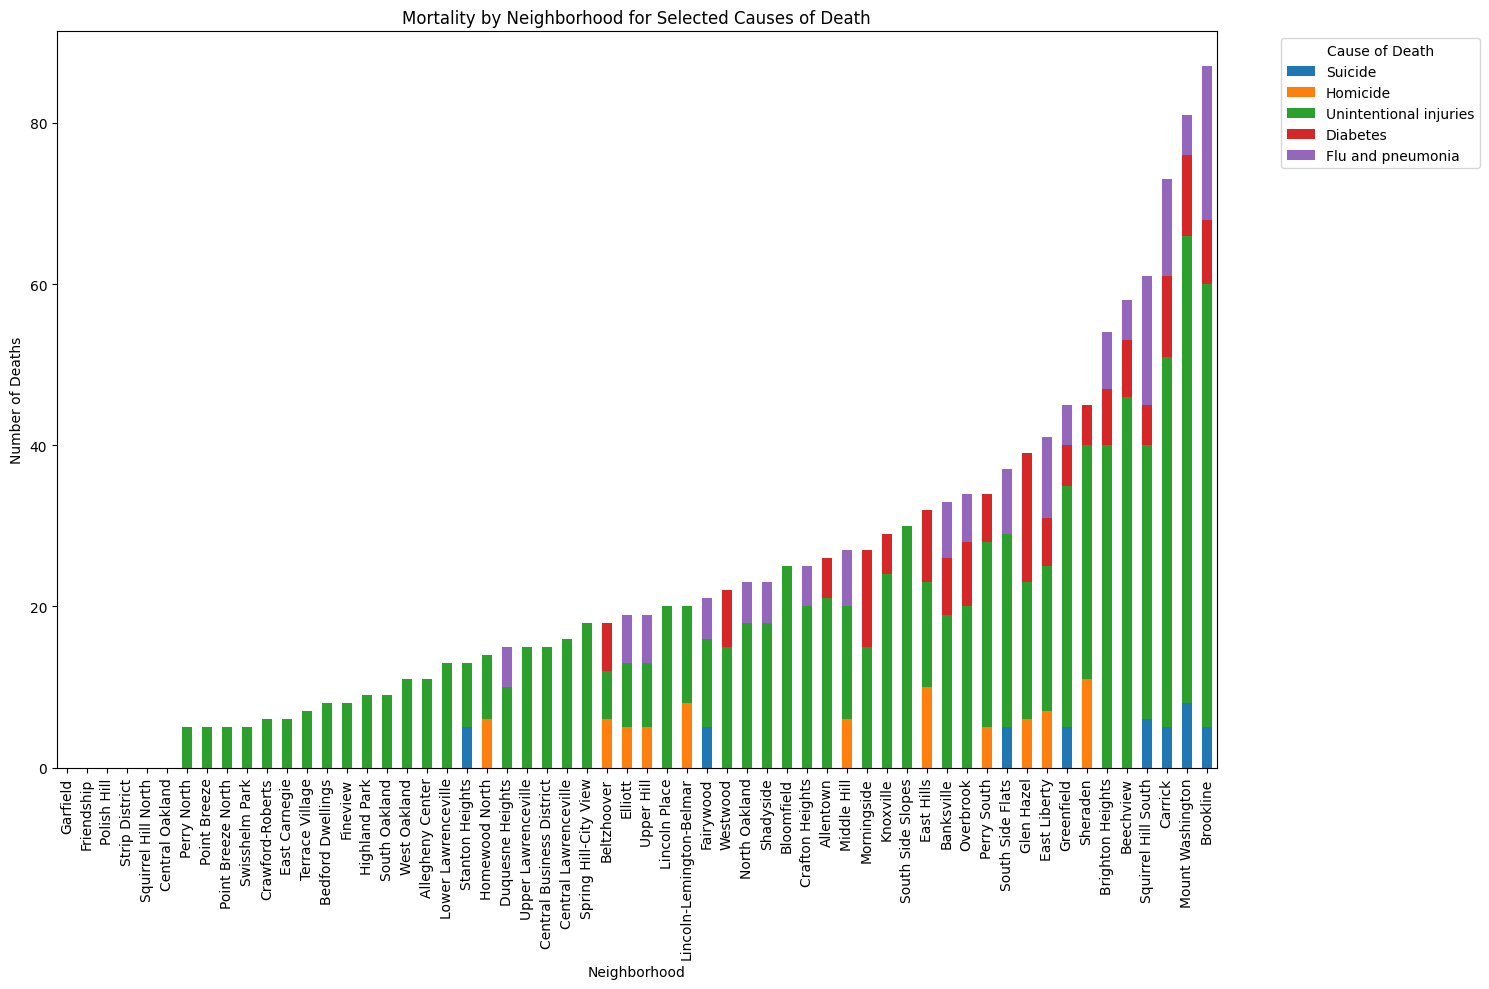

In [18]:
# Filter and sort by total deaths per neighborhood
relevant_causes = ["Suicide", "Homicide", "Unintentional injuries", "Diabetes", "Flu and pneumonia"]
joined_gdf['total_deaths'] = joined_gdf[relevant_causes].sum(axis=1)

# Group by neighborhood and get the bottom 100 by total deaths
grouped_df = joined_gdf.groupby('hood')[relevant_causes + ['total_deaths']].sum()
bottom_100 = grouped_df.sort_values(by='total_deaths', ascending=True).head(100)

# Drop the 'total_deaths' column for plotting
bottom_100 = bottom_100.drop(columns=['total_deaths'])

# Plotting
bottom_100.plot(kind='bar', stacked=True, figsize=(15, 10))
plt.xlabel('Neighborhood')
plt.ylabel('Number of Deaths')
plt.title('Mortality by Neighborhood for Selected Causes of Death')
plt.legend(title='Cause of Death', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



## Step 5: Loading the Shapefile & Mapping to Geography

I wanted to include another graph to have a more geographic representation of the data.  I loaded a shapefile into the program and then matched the `Census_Tract` in the `mortality_by_tract.csv` with the `GEOID` in the `Allegheny_County_Census_Tracts_2020.shp`. I then merged the dataframe and shapefiles and filtered the results for what I desired as above.  Finally, I created a heatmap for a more geographically-oriented approach of the data.

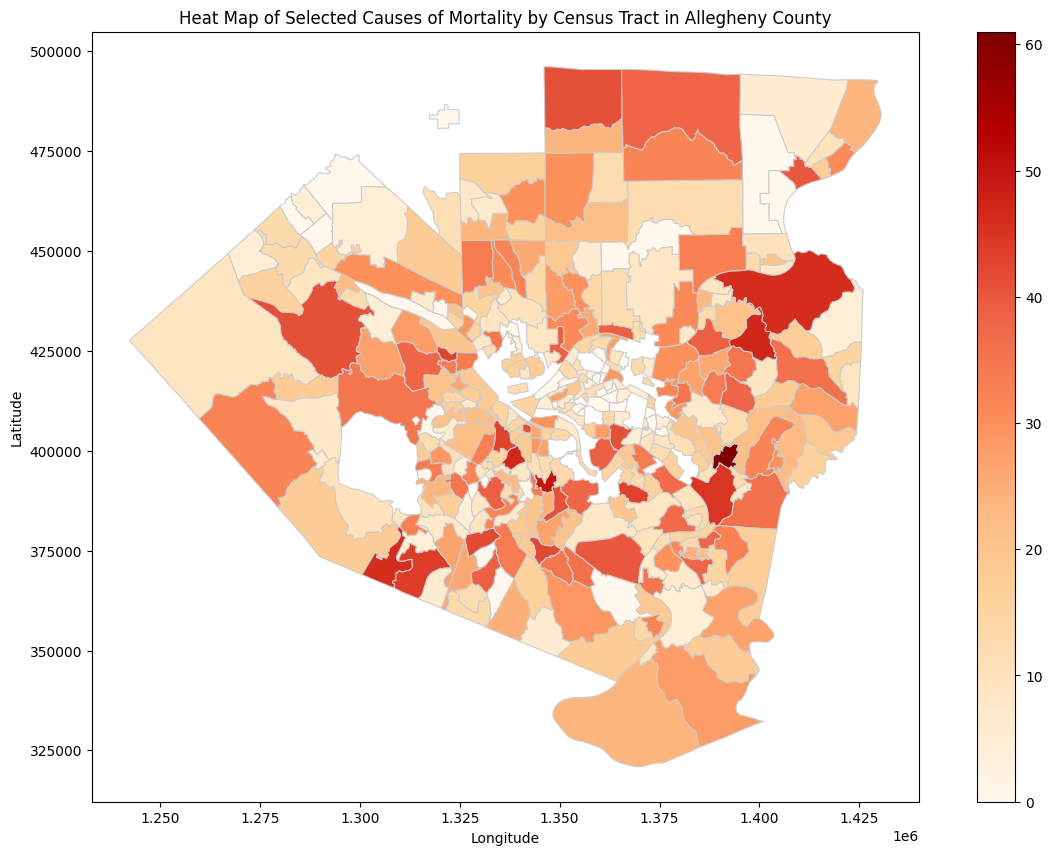

In [19]:
# Load the shapefile
shapefile_path = 'Allegheny_County_Census_Tracts_2020/Allegheny_County_Census_Tracts_2020.shp'
gdf = gpd.read_file(shapefile_path)

# Reset index to access 'Census_Tract' column
df.reset_index(inplace=True)

# Convert 'Census_Tract' to string to match 'GEOID'
df['Census_Tract'] = df['Census_Tract'].astype(str)
gdf['GEOID'] = gdf['GEOID'].astype(str)

# Merge the shapefile GeoDataFrame with the mortality DataFrame
merged_gdf = gdf.merge(df, left_on='GEOID', right_on='Census_Tract')

# Create a new column that sums the specified causes
relevant_causes = ["Suicide", "Homicide", "Unintentional injuries", "Diabetes", "Flu and pneumonia"]
merged_gdf['Selected Causes'] = merged_gdf[relevant_causes].sum(axis=1)

# Plot the heat map for the combined column
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_gdf.plot(column='Selected Causes', cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Add labels and title
plt.title('Heat Map of Selected Causes of Mortality by Census Tract in Allegheny County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


## Conclusion: Neighborhoods With the Lowest Mortalities

According to the dataset & graph, the top ten best neighborhoods with the lowest mortalities are as follows:

1. Central Oakland  
1. Friendship   
1. Garfield
1. Polish Hill
1. Squirrel Hill North
1. Strip District
1. Point Breeze
1. Point Breeze North
1. Swisshelm Park
1. Perry North

## Particulate Matter

### By Joshua Sakolsky-Madaras

_________________________________________________________________________________________________________________________________________________

Another way to measure the overall health and wellness of a specific area is air quality, especially in Pittsburgh. With a history of steel production brining much pollution into the air a key aspect of finding the best neighborhood is which ones have the least particulate matter in the air.

Data Set Used: [Allegheny County Particulate Matter](https://data.wprdc.org/dataset/particulate-matter-2-5)

This dataset is provided by the EPA.

In [20]:
# Imports needed
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("pm2.52011ct.csv")

# Show the first 5 rows of the dataframe
df.head(5)

,CensusTract,PM25
0,10300,12.264655
1,20100,12.283052
2,20300,12.241216
3,30500,12.234197
4,40200,12.315312


## Step 1: Adding In Census Info & Merging

I read the census tract values here and merge them with the `CensusTract` values within the dataset of the particulate matter values.

In [21]:
# Load the census tract data with latitude and longitude
tracts_df = pd.read_csv("Allegheny_County_Census_Tracts_2020.csv")

# Adjusting the CensusTract formatting to only include the last 6 digits
df['CensusTract'] = df['CensusTract'].astype(str).str.zfill(6)
tracts_df['CensusTract'] = tracts_df['GEOID'].astype(str).str[-6:]

# Merging on the adjusted CensusTract
merged_df = pd.merge(df, tracts_df, on='CensusTract')

# Display the first 5 rows of the merged dataframe
merged_df.head(5)

,CensusTract,PM25,FID,STATEFP,COUNTYFP,TRACTCE,GEOID,GEOIDFQ,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape__Area,Shape__Length
0,020100,12.283052,190,42,3,20100,42003020100,1400000US42003020100,201.0,Census Tract 201,G5020,S,1427891,465722,40.440662,-80.001277,2.038098e+07,20399.907349
1,020300,12.241216,201,42,3,20300,42003020300,1400000US42003020300,203.0,Census Tract 203,G5020,S,1590870,326538,40.454500,-79.981276,2.063713e+07,24574.104834
2,030500,12.234197,270,42,3,30500,42003030500,1400000US42003030500,305.0,Census Tract 305,G5020,S,927620,0,40.442113,-79.985307,9.983961e+06,14774.816642
3,040200,12.315312,271,42,3,40200,42003040200,1400000US42003040200,402.0,Census Tract 402,G5020,S,604860,0,40.440110,-79.966247,6.510111e+06,16507.286891
4,040400,12.245356,324,42,3,40400,42003040400,1400000US42003040400,404.0,Census Tract 404,G5020,S,194956,0,40.447362,-79.949426,2.098310e+06,6592.966427


## Step 2: Creating GeoDataFrame & Loading Neighborhood Data

Here I preform the same exact process as I did in the mortality indicators analysis. In order to map the `CensusTract` values to actual neighborhoods in Pittsburgh I had to create a GeoDataFrame, as I am using longitude and latitude values. I also needed the data of the neighborhoods in Pittsburgh to define thier locations for mapping of the `CensusTract` values.

In [22]:
# Create a GeoDataFrame using latitude and longitude
merged_df['geometry'] = merged_df.apply(lambda row: Point(float(row['INTPTLON']), float(row['INTPTLAT'])), axis=1)
gdf_df = gpd.GeoDataFrame(merged_df, geometry='geometry')

# Set the initial CRS (assuming WGS 84)
gdf_df.set_crs(epsg=4326, inplace=True)

# Load neighborhoods shapefile
neighborhoods_gdf = gpd.read_file('neighborhoods/Neighborhoods_.shp')

## Step 3: Match Checking & Joining

Once again, this is the same process I used when creating the visualizations for the mortality indicators. Here is where I had to check that the location values for the tracts and neighborhoods actually lined up. Once that was all good, I then used a spatial join to combine the location of the neighborhoods with the census tracts.

In [23]:
# Ensure CRS matches between the two GeoDataFrames
if gdf_df.crs != neighborhoods_gdf.crs:
    gdf_df.to_crs(neighborhoods_gdf.crs, inplace=True)

# Perform spatial join
joined_gdf = gpd.sjoin(gdf_df, neighborhoods_gdf, how='left', predicate='within')

## Step 4: Ordering & Plotting

The data within the particulate matter dataset was very simple, they were not even any NaN/null values.  All I did here was group them by neighborhood and take the mean of each of thier particulate matter. I then ordered the bottom 50 neighborhoods, with the least particulate matter in ascending order. I did end up editing the y axis a lot because the change in particulate matter would not be as easy to see if it were 0 to 12.5.

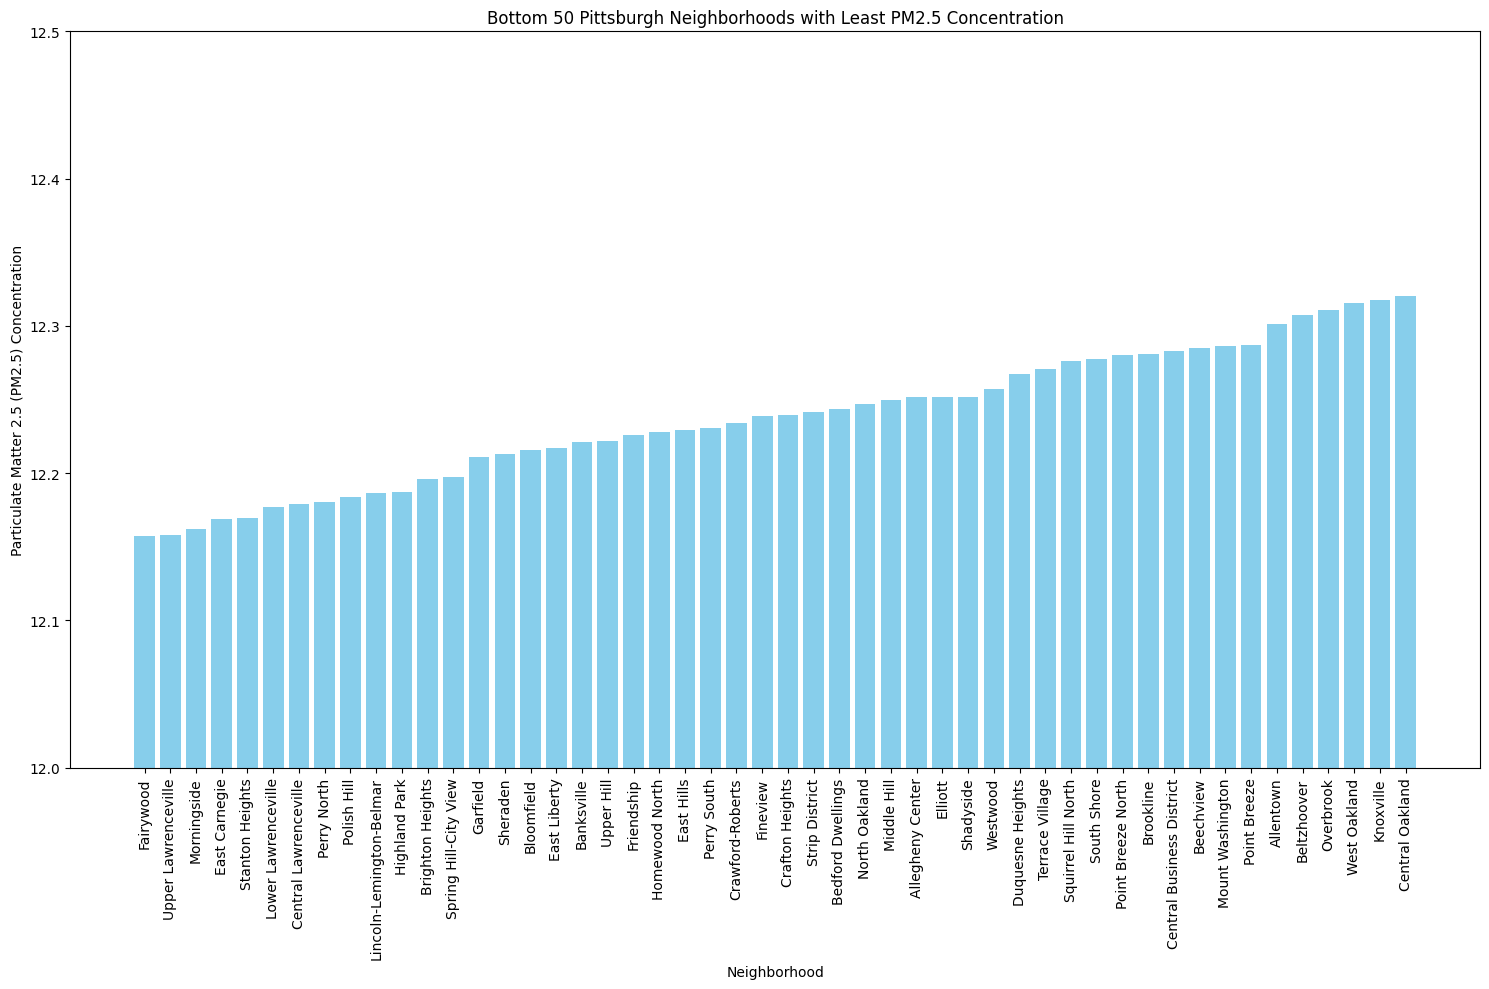

In [24]:
# Group by neighborhood and calculate the mean PM2.5 for each neighborhood
neighborhood_pm25 = joined_gdf.groupby('hood')['PM25'].mean().reset_index()

# Sort the neighborhoods by PM2.5 in ascending order and select the bottom 50
bottom_50_neighborhoods = neighborhood_pm25.nsmallest(50, 'PM25')

# Plot the bar graph
plt.figure(figsize=(15, 10))
plt.bar(bottom_50_neighborhoods['hood'], bottom_50_neighborhoods['PM25'], color='skyblue')
plt.xlabel('Neighborhood')
plt.ylabel('Particulate Matter 2.5 (PM2.5) Concentration')
plt.title('Bottom 50 Pittsburgh Neighborhoods with Least PM2.5 Concentration')
plt.xticks(rotation=90)
plt.ylim(12, 12.5)  # Set the y-axis limits from 11 to 13
plt.tight_layout()
plt.show()

## Step 5: Mapping the Data Geographically

Just like with the mortality data, I wanted to include another graph to have a more geographic representation of the data.  I loaded a shapefile into the program and then matched the `CensusTract` in the `pm2.52011ct.csv` with the `GEOID` in the `Allegheny_County_Census_Tracts_2020.shp`. I then merged the dataframe and shapefiles and filtered the results for what I desired as above.  Finally, I created a heatmap for a more geographically-oriented approach of the data.

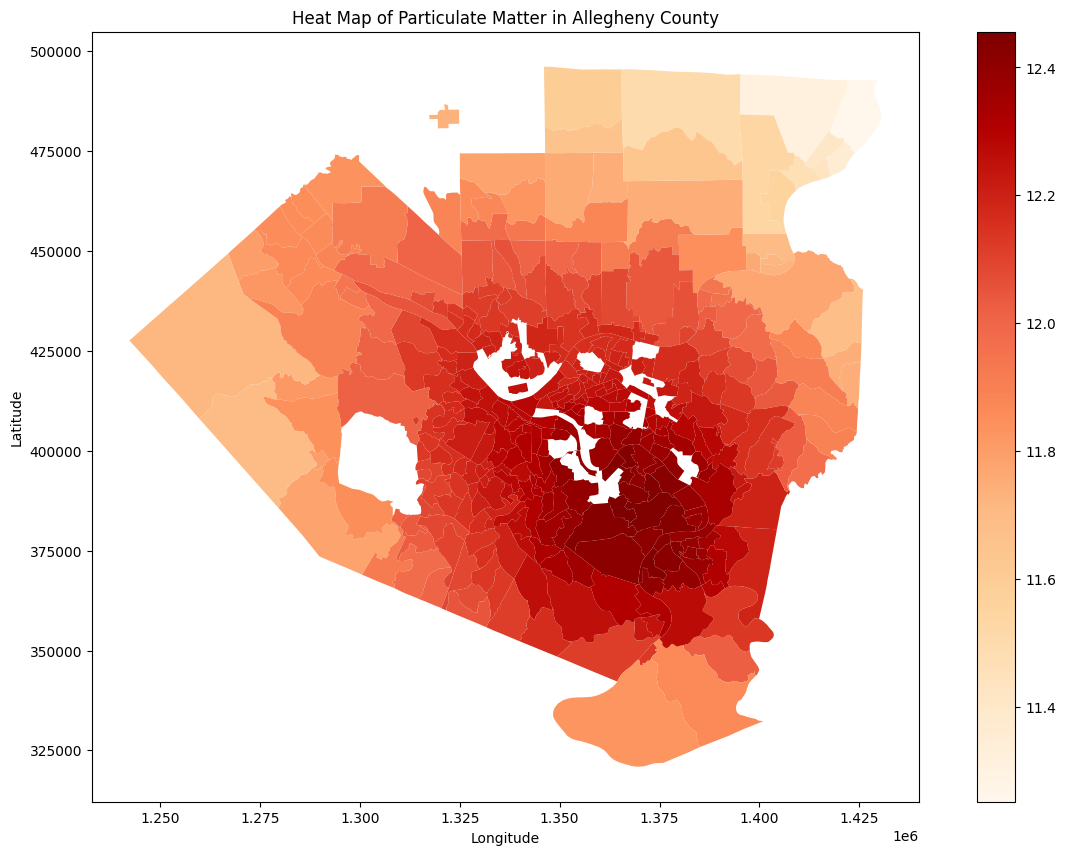

In [25]:
# Load the shapefile
shapefile_path = 'Allegheny_County_Census_Tracts_2020/Allegheny_County_Census_Tracts_2020.shp'
gdf = gpd.read_file(shapefile_path)

# Reset index to access 'Census_Tract' column
df.reset_index(inplace=True)

# Adjust CensusTract formatting to only include the last 6 digits
df['CensusTract'] = df['CensusTract'].astype(str).str[-6:]
gdf['CensusTract'] = gdf['GEOID'].astype(str).str[-6:]

# Merge GeoDataFrame with the DataFrame on 'CensusTract'
merged_gdf = gpd.GeoDataFrame(pd.merge(gdf, df, on='CensusTract'))

# Plot the heat map for the PM2.5 column
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_gdf.plot(column='PM25', cmap='OrRd', linewidth=0.8, ax=ax, legend=True)

# Add labels and title
plt.title('Heat Map of Particulate Matter in Allegheny County')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

## Conclusion: Neighborhoods With the Lowest Particulate Matter

According to the dataset & graph, the top ten best neighborhoods with the lowest particulate matter are as follows:

1. Fairywood
1. Upper Lawrenceville
1. Morningside
1. East Carnegie
1. Stanton Heights
1. Lower Lawrence
1. Central Lawrenceville
1. Perry North
1. Polish Hill
1. Lincoln-Lemington-Belmar
